# Работу выполнил Девятов Денис Сергеевич БПИ-238

https://github.com/BelyLandy/Assignment-5-Bonus--238

https://chat.deepseek.com/share/e7kiwudrbw85jnih21

# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


**1) What kind of machine learning problem is this? (classification, sequence labeling, etc.)**

В рамках этого датасета это multi-class text classification на уровне упоминания mention-level classification или entity typing. Нам уже задано упоминание `entity` в документе, и задача - определить его тип из пяти классов, а именно `PER/ORG/LOC/EVT/PRO`. Это **не** полноценный NER как sequence labeling, потому что в данных нет координат сущности в тексте, а значит мы не учим модель находить спаны, мы только классифицируем уже известные mentions.

$$$$

**2) How can this be formulated as a supervised learning problem?**

Это формулируется как supervised learning очень прямо:

* X (признаки). Строка `entity` и плюсом контекст `document_text`.
* y (таргет). `gold_answer` ∈ {PER, ORG, LOC, EVT, PRO}.

Важно делить данные по документам (group split), чтобы не было утечки. Один и тот же текст не должен попадать и в train, и в test.

$$$$

**3) What classical ML methods exist for solving it?**

Для такой классификация текста хорошо подходят классические модели с мешком слов или символов, а именно

* Logistic Regression и Linear SVM на TF-IDF признаках.
* Multinomial Naive Bayes (быстрый, но может быть слабее на сложных классах).

Так как `entity` короткая строка, полезны символьные n-граммы. А для контекста - word n-граммы по документу.

$$$$

**4) How can it be solved using modern LLMs like DeepSeek?**

LLM можно использовать как baseline. Дать текст документа и плюс список (или одно) entity и попросить вернуть тип из {PER, ORG, LOC, EVT, PRO}. Чтобы ответы были сравнимы и парсились автоматически, важно жёстко задать формат и запретить любые пояснения.

$$$$

**5) What are the assumptions of different model classes?**

Линейные модели предполагают, что классы хорошо отделяются линейно в пространстве признаков TF-IDF. Они устойчивы на маленьких данных, но сильно зависят от качества фичей. Naive Bayes предполагает условную независимость признаков и часто хорошо работает на простых текстовых сигналах, но хуже учитывает сложный контекст. LLM, наоборот, использует знания и контекст из предобучения, но её поведение менее детерминировано, так как может быть нестабильный формат и случайные ошибки.

$$$$

**6) How is model quality typically evaluated in this task? What metrics are appropriate and why?**

Так как у нас одна метка на один mention, то стандартные метрики - это:

* Accuracy.
* **Macro-F1** (важна при дисбалансе классов, так как даёт равный вес каждому классу).
* Отчёты precision/recall/F1 по каждому классу с confusion matrix, чтобы понимать, какие типы путаются.

Ограничение такое что датасет маленький и классы несбалансированы, поэтому метрики могут сильно зависеть от того, какие документы попали в test/val.

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [197]:
import pandas as pd
from pathlib import Path

RU_TXT_DIR = Path("/content/ru_txt")
RU_OUT_DIR = Path("/content/ru_out")

def norm_doc_id(s: str) -> str:
    return s.strip().replace("_", "-")

doc_text = {}
for txt_path in sorted(RU_TXT_DIR.glob("*.txt")):
    lines = txt_path.read_text(encoding="utf-8").splitlines()
    doc_id = norm_doc_id(lines[0]) if len(lines) > 0 else norm_doc_id(txt_path.stem)
    text = "\n".join(lines[4:]).strip() if len(lines) > 4 else ""
    doc_text[doc_id] = text

rows = []
for out_path in sorted(RU_OUT_DIR.glob("*.out")):
    lines = out_path.read_text(encoding="utf-8").splitlines()
    if not lines:
        continue

    doc_id = norm_doc_id(lines[0])
    text = doc_text.get(doc_id, "")

    for line in lines[1:]:
        if not line.strip():
            continue
        parts = line.split("\t")
        if len(parts) < 3:
            continue

        entity_mention = parts[0].strip()
        coarse_label = parts[2].strip()

        rows.append({
            "document_id": doc_id,
            "document_text": text,
            "entity": entity_mention,
            "gold_answer": coarse_label
        })

df = pd.DataFrame(rows)

display(df.head())

print("Размер df:", df.shape)
print("Документов:", df["document_id"].nunique())
print("\nРаспределение классов (gold_answer):")
print(df["gold_answer"].value_counts())
print("\nУникальных entity-упоминаний:", df["entity"].nunique())

,document_id,document_text,entity,gold_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit,EVT
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбиона,LOC
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбионе,LOC
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Борис Джонсон,PER
4,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британии,LOC


Размер df: (153, 4)
Документов: 9

Распределение классов (gold_answer):
gold_answer
PER    63
ORG    36
LOC    36
EVT    13
PRO     5
Name: count, dtype: int64

Уникальных entity-упоминаний: 80


In [198]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
y = le.fit_transform(df["gold_answer"])

print("Классы:", list(le.classes_))

vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(2, 5),
    min_df=1
)

X = vectorizer.fit_transform(df["entity"])

print("X shape:", X.shape, "| y shape:", y.shape)

Классы: ['EVT', 'LOC', 'ORG', 'PER', 'PRO']
X shape: (153, 1321) | y shape: (153,)


In [199]:
df.to_csv("brexit_ner_dataset.csv", index=False)
print("Сохранил:", "brexit_ner_dataset.csv")

Сохранил: brexit_ner_dataset.csv


In [200]:
required = ["document_id", "document_text", "entity", "gold_answer"]
print("Все обязательные колонки есть:", set(required).issubset(df.columns))
print("\nПропуски по обязательным колонкам:")
print(df[required].isna().sum())

Все обязательные колонки есть: True

Пропуски по обязательным колонкам:
document_id      0
document_text    0
entity           0
gold_answer      0
dtype: int64


In [201]:
print("Пустые document_text:", (df["document_text"].str.len() == 0).sum())

Пустые document_text: 0


#**Итог.**

Я собрал датасет из наших 9 пар файлов, которые `.txt`, `.out` и привёл его к единому формату.  
Каждая строка в таблице - это одно упоминание сущности из конкретного документа:  
- `document_id` - id документа,  
- `document_text` - полный текст документа,  
- `entity` - текстовое упоминание сущности,  
- `gold_answer` - целевая метка сущности из набора {PER, ORG, LOC, EVT, PRO}.

Получилось 153 примера из 9 документов. Пропусков в обязательных колонках нет, пустых текстов тоже нет.  
По распределению классов видно, что датасет несбалансирован, например, PER встречается чаще, PRO и EVT заметно реже, это важно учитывать дальше при выборе метрик и при разбиении.

$$$$

Для базового ML-подхода я превратил столбец entity в признаки через TF-IDF по символьным n-граммам (2–5). Такой вариант неплохо сработал для NER-упоминаний, потому что уловил все окончания и морфологию и также устойчив к склонениям. В итоге матрица признаков имеет размер **(153, 1321)**.

$$$$

##**Замечания по качеству данных.**
- В `.out` файлах нет координат сущностей в тексте, поэтому в этой домашке задача фактически упрощается до классификации упоминания (entity -> тип).
- В данных могут быть дубликаты и разные формы одного и того же объекта (например, Брюссель / Брюсселю / Брюсселя), что нормально для формата новостей, но влияет на статистику и обучение.
- Чтобы избежать утечки, корректнее делать сплит по документам document_id, а не случайно по строкам, иначе одинаковые сущности из одного текста могут попасть и в train, и в test.

Также я сохранил собранный датасет в файл `brexit_ner_dataset.csv` для дальнейших эээкспериментов.


### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [202]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd

groups = df["document_id"].values

gss1 = GroupShuffleSplit(n_splits=1, test_size=2/9, random_state=42)
train_val_idx, test_idx = next(gss1.split(df, groups=groups))

df_train_val = df.iloc[train_val_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

groups_train_val = df_train_val["document_id"].values
gss2 = GroupShuffleSplit(n_splits=1, test_size=1/7, random_state=42)
train_idx, val_idx = next(gss2.split(df_train_val, groups=groups_train_val))

df_train = df_train_val.iloc[train_idx].reset_index(drop=True)
df_val = df_train_val.iloc[val_idx].reset_index(drop=True)

print("=== Размеры сплитов ===")
print(f"Train: {df_train.shape} | документов: {df_train['document_id'].nunique()}")
print(f"Val: {df_val.shape} | документов: {df_val['document_id'].nunique()}")
print(f"Test: {df_test.shape} | документов: {df_test['document_id'].nunique()}")

print("\n=== Распределение классов (gold_answer) ===")
def show_dist(name, d):
    vc = d["gold_answer"].value_counts()
    print(f"\n{name}:")
    print(vc)
    print("Доли:")
    print((vc / len(d)).round(3))

show_dist("Train", df_train)
show_dist("Val", df_val)
show_dist("Test", df_test)

print("\nДокументы в сплитах, то есть проверяем, что не пересекаются:")
print("Train docs:", sorted(df_train["document_id"].unique()))
print("Val docs: ", sorted(df_val["document_id"].unique()))
print("Test docs: ", sorted(df_test["document_id"].unique()))

=== Размеры сплитов ===
Train: (77, 4) | документов: 6
Val: (44, 4) | документов: 1
Test: (32, 4) | документов: 2

=== Распределение классов (gold_answer) ===

Train:
gold_answer
PER    37
ORG    19
LOC    13
EVT     6
PRO     2
Name: count, dtype: int64
Доли:
gold_answer
PER    0.481
ORG    0.247
LOC    0.169
EVT    0.078
PRO    0.026
Name: count, dtype: float64

Val:
gold_answer
LOC    20
ORG    11
PER     8
EVT     5
Name: count, dtype: int64
Доли:
gold_answer
LOC    0.455
ORG    0.250
PER    0.182
EVT    0.114
Name: count, dtype: float64

Test:
gold_answer
PER    18
ORG     6
PRO     3
LOC     3
EVT     2
Name: count, dtype: int64
Доли:
gold_answer
PER    0.562
ORG    0.188
PRO    0.094
LOC    0.094
EVT    0.062
Name: count, dtype: float64

Документы в сплитах, то есть проверяем, что не пересекаются:
Train docs: ['ru-1001', 'ru-1002', 'ru-1003', 'ru-1004', 'ru-1006', 'ru-1017']
Val docs:  ['ru-10']
Test docs:  ['ru-1000', 'ru-1011']


In [203]:
def deepseek_prompt_from_row(row: pd.Series) -> str:
    doc_id = row["document_id"]
    entity = row["entity"]
    text = row["document_text"]

    prompt = f"""Ты решаешь задачу NER-классификации упоминания.
Нужно определить тип сущности для указанного упоминания из списка: PER, ORG, LOC, EVT, PRO.

Документ ID: {doc_id}
Упоминание (entity): {entity}

Текст документа:
\"\"\"{text}\"\"\"

Ответ верни СТРОГО в JSON без лишнего текста:
{{"document_id": "{doc_id}", "entity": "{entity}", "pred_label": "<PER|ORG|LOC|EVT|PRO>"}}
"""
    return prompt

print(deepseek_prompt_from_row(df_train.iloc[0]))

Ты решаешь задачу NER-классификации упоминания.
Нужно определить тип сущности для указанного упоминания из списка: PER, ORG, LOC, EVT, PRO.

Документ ID: ru-1001
Упоминание (entity): Associated Press

Текст документа:
"""Глава МИД Британии Борис Джонсон подал в отставку

Министр иностранных дел Великобритании Борис Джонсон ушел в отставку. Об этом сообщает Associated Press. Премьер-министр Тереза Мэй приняла отставку Джонсона. "Премьер поблагодарила Бориса за работу. О том, кто станет новым министром, будет объявлено в ближайшее время", - сообщили также в канцелярии премьера.

Ранее Мэй пообещала отправить в отставку Джонсона, если он откажется принять ее позицию по плавному выходу из Евросоюза. Напомним, что Джонсон является сторонником жесткого Brexit . Он уверен, что план Мэй, который подразумевает создание зоны свободной торговли с ЕС, сохранит зависимость Соединенного Королевства от Евросоюза."""

Ответ верни СТРОГО в JSON без лишнего текста:
{"document_id": "ru-1001", "entity": "

Тут я считаю важно не допустить утечки. В одном документе встречаются одни и те же сущности и их формы, поэтому неправильный split даст завышенные метрики.

Ну и поэтому я делаю разбиение по документам `document_id`:
- train - документы для обучения,
- val - документы для подбора или проверки гиперпараметров,
- test - документы для финальной оценки.

Такой split лучше отражает реальную задачу. Модель видит новые тексты на тесте, а не фрагменты уже знакомых документов.

$$$$

Разбиение сделано по документам. Пересечений `document_id` между train/val/test нет. По сути это главное требование, чтобы не было утечки одинаковых сущностей или форм слов между сплитами.

$$$$

Размеры сплитов получились такие, что по Train 77 строк и 6 документов, у Val 44 строки и 1 документ, и Test 32 строки и 2 документа.

$$$$

Распределение классов между сплитами похоже, но не прям идеально одинаковое, учитывая что у нас всего 9 документов. Например, PRO редкий класс и прыгает по долям. В том же train его всего 2 примера, в val вообще нет, а в test 3 штуки. Это означает, что метрики могут быть шумными и это важно помнить, делая выводы.

Ну и функция `deepseek_prompt_from_row` формирует понятный промпт. Даёт контекст документа и конкретное упоминание и просит вернуть ответ строго, чтобы потом легко парсить и сравнивать с ML-моделями.

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


In [204]:
import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

ALL_LABELS = np.array(["EVT", "LOC", "ORG", "PER", "PRO"], dtype=str)
le = LabelEncoder()
le.fit(ALL_LABELS)

y_train = le.transform(df_train["gold_answer"].astype(str))
y_val   = le.transform(df_val["gold_answer"].astype(str))
y_test  = le.transform(df_test["gold_answer"].astype(str))

print("Классы:", list(le.classes_))

def select_entity(X):
    return X["entity"].astype(str)

def select_text(X):
    return X["document_text"].astype(str)

get_entity = FunctionTransformer(select_entity, validate=False)
get_text   = FunctionTransformer(select_text, validate=False)

entity_vect = Pipeline([
    ("sel", get_entity),
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(2,5), min_df=1))
])

text_vect = Pipeline([
    ("sel", get_text),
    ("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=1, max_features=20000))
])

features = FeatureUnion([
    ("entity", entity_vect),
    ("text", text_vect)
])

models = {
    "LogReg": Pipeline([
        ("features", features),
        ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ]),
    "LinearSVC": Pipeline([
        ("features", features),
        ("clf", LinearSVC(class_weight="balanced"))
    ]),
    "MultinomialNB": Pipeline([
        ("features", features),
        ("clf", MultinomialNB())
    ]),
}

results = {}
for name, pipe in models.items():
    print(f"\n=== Обучаю {name} ===")
    pipe.fit(df_train, y_train)

    pred_val = pipe.predict(df_val)
    f1_val_macro = f1_score(y_val, pred_val, average="macro")
    f1_val_micro = f1_score(y_val, pred_val, average="micro")

    print(f"{name}: F1(val) macro = {f1_val_macro:.4f}, micro = {f1_val_micro:.4f}")
    results[name] = (f1_val_macro, f1_val_micro)

    joblib.dump(pipe, f"{name}_brexit_ner.joblib")
    print(f"Сохранил модель: {name}_brexit_ner.joblib")

best_name = max(results, key=lambda k: results[k][0])
print(f"\nЛучшая модель по val macro-F1: {best_name}")

df_train_full = pd.concat([df_train, df_val], ignore_index=True)
y_train_full = le.transform(df_train_full["gold_answer"].astype(str))

best_model = models[best_name]
best_model.fit(df_train_full, y_train_full)

pred_test = best_model.predict(df_test)
print("\n=== Качество на тесте (best retrained on train+val) ===")
print("F1(test) macro:", f1_score(y_test, pred_test, average="macro"))
print("F1(test) micro:", f1_score(y_test, pred_test, average="micro"))
print("\nОтчёт по классам (test):")
print(classification_report(y_test, pred_test, target_names=le.classes_))

joblib.dump(best_model, f"{best_name}_brexit_ner_FINAL.joblib")
print(f"\nСохранил финальную модель: {best_name}_brexit_ner_FINAL.joblib")

Классы: [np.str_('EVT'), np.str_('LOC'), np.str_('ORG'), np.str_('PER'), np.str_('PRO')]

=== Обучаю LogReg ===
LogReg: F1(val) macro = 0.6851, micro = 0.6136
Сохранил модель: LogReg_brexit_ner.joblib

=== Обучаю LinearSVC ===
LinearSVC: F1(val) macro = 0.6851, micro = 0.6136
Сохранил модель: LinearSVC_brexit_ner.joblib

=== Обучаю MultinomialNB ===
MultinomialNB: F1(val) macro = 0.3725, micro = 0.3864
Сохранил модель: MultinomialNB_brexit_ner.joblib

Лучшая модель по val macro-F1: LogReg

=== Качество на тесте (best retrained on train+val) ===
F1(test) macro: 0.9446153846153846
F1(test) micro: 0.96875

Отчёт по классам (test):
              precision    recall  f1-score   support

         EVT       1.00      1.00      1.00         2
         LOC       1.00      1.00      1.00         3
         ORG       0.86      1.00      0.92         6
         PER       1.00      1.00      1.00        18
         PRO       1.00      0.67      0.80         3

    accuracy                          

In [205]:
import numpy as np
import pandas as pd
# Собственно вот чат со всеми промптами для получения нужных данных.
# https://chat.deepseek.com/share/e7kiwudrbw85jnih21
# Формат строк: entity<TAB>label
deepseek_raw_by_doc = {
    "ru-10": """Brexit\tEVT
Альбиона\tLOC
Альбионе\tLOC
Борис Джонсон\tPER
Британии\tLOC
Британия\tLOC
Брюсселе\tLOC
Брюсселем\tLOC
Брюссель\tLOC
Брюсселю\tLOC
Брюсселя\tLOC
Джонсон\tPER
Джонсона\tPER
ЕС\tORG
Еврокомиссия\tORG
Европа\tLOC
Европе\tLOC
Европейскому\tORG
Европой\tLOC
Европы\tLOC
Евросоюза\tORG
Евросоюзом\tORG
Консервативной партии\tORG
Ла-Манша\tLOC
Лондон\tLOC
Лондона\tLOC
Лондоне\tLOC
Лондону\tLOC
Международного валютного фонда\tORG
Мишелю Барнье\tPER
Мэй\tPER
Себастьян Курц\tPER
Северную Ирландию\tLOC
Соединенного Королевства\tLOC
Тереза Мэй\tPER
Терезу\tPER
брекзит\tEVT
брекзита\tEVT
брекзиту\tEVT
брексит\tEVT
британском парламенте\tORG
британскому парламентам\tORG
лейбористы\tORG
тори\tORG
""",
    "ru-1000": """Brexit\tEVT
The Guardian\tORG
Борис Джонсон\tPER
Бориса Джонсона\tPER
Бориса\tPER
Великобритании\tLOC
Джонсон\tPER
Дэвид Дэвис\tPER
ЕС\tORG
МИД Соединенного Королевства\tORG
Подробности.ua\tORG
Стив Бейкер\tPER
Тереза Мэй\tPER
УНН	ORG
""",
    "ru-1001": """Associated Press\tORG
Brexit\tEVT
Борис Джонсон\tPER
Бориса\tPER
Великобритании\tLOC
Джонсон\tPER
Джонсона\tPER
ЕС\tORG
Евросоюза\tORG
Евросоюза\tORG
МИД Британии\tORG
Мэй\tPER
Соединенного Королевства\tLOC
Тереза Мэй\tPER
""",
    "ru-1002": """Бориса Джонсона\tPER
Брекзит\tEVT
Великобритании\tLOC
Дэвид Дэвис\tPER
ЕС\tORG
Евросоюза\tORG
Тереза Мей\tPER
""",
    "ru-1003": """Борис Джонсон\tPER
Великобритании\tLOC
Даунинг-Стрит\tLOC
Джонсона\tPER
Дэвид Дэвис\tPER
Евросоюза\tORG
Мэй\tPER
Рейтер\tORG
Тереза Мэй\tPER
брекзита\tEVT
""",
    "ru-1004": """Brexit\tEVT
Борис Джонсон\tPER
Германии\tLOC
Джонсон\tPER
Джонсона\tPER
Дэвид Дэвис\tPER
Дэвис\tPER
ЕС\tORG
Евросоюзом\tORG
Западных Балкан\tLOC
Консервативной партии\tORG
Лондоне\tLOC
МИД Великобритании\tORG
МИД\tORG
Мэй\tPER
Польши\tLOC
ТАСС\tORG
Терезы Мэй\tPER
""",
    "ru-1006": """Brexit\tEVT
Facebook\tPRO
Борис Джонсон\tPER
Бориса Джонсона\tPER
Британии\tLOC
Великобритании\tLOC
Джонсона\tPER
Захарова\tPER
Захаровой\tPER
МИД России\tORG
Мария Захарова\tPER
Мэй\tPER
Т. Мэй\tPER
""",
    "ru-1011": """Brexit\tEVT
The Guardian\tORG
Борис Джонсон\tPER
Бориса Джонсона\tPER
Борисом Джонсоном\tPER
Великобританией\tLOC
Великобритании\tLOC
Джонсона\tPER
Джонсоном\tPER
Дэвид Дэвис\tPER
Дэвисом\tPER
ЕС\tORG
Евросоюза\tORG
Мэй\tPER
Палате общин\tORG
Тереза Мэй\tPER
Терезу Мэй\tPER
Терезы Мэй\tPER
""",
    "ru-1017": """Brexit\tEVT
The Guardian\tORG
Борис Джонсон\tPER
Бориса Джонсона\tPER
Бориса Джонсона\tPER
Бориса\tPER
Великобритании\tLOC
Джонсон\tPER
Дэвид Дэвис\tPER
ЕС\tORG
КИЕВ\tLOC
МИД Соединенного Королевства\tORG
Стив Бейкер\tPER
Тереза Мэй\tPER
УНН\tORG
""",
}

ALLOWED = {"PER", "ORG", "LOC", "EVT", "PRO"}

def parse_deepseek_tsv(raw: str):
    pairs = []
    raw = (raw or "").strip()
    if raw == "" or raw == "...":
        return pairs

    for line in raw.splitlines():
        line = line.strip()
        if not line:
            continue

        if "\t" in line:
            ent, lab = line.split("\t", 1)
        else:
            parts = line.split()
            ent, lab = " ".join(parts[:-1]), parts[-1]

        ent = ent.strip()
        lab = lab.strip().upper()

        pairs.append((ent, lab))

    return pairs

deepseek_entities_by_doc = {
    doc_id: parse_deepseek_tsv(raw)
    for doc_id, raw in deepseek_raw_by_doc.items()
}

bad = []
for doc_id, pairs in deepseek_entities_by_doc.items():
    for ent, lab in pairs:
        if lab not in ALLOWED:
            bad.append((doc_id, ent, lab))
if bad:
    raise ValueError(f"DeepSeek вернул неизвестные метки (первые 10): {bad[:10]}")

ds_rows = []
for doc_id, pairs in deepseek_entities_by_doc.items():
    for ent, lab in pairs:
        ds_rows.append({"document_id": doc_id, "entity": ent, "deepseek_pred": lab})

df_deepseek = pd.DataFrame(ds_rows)
print("DeepSeek rows:", df_deepseek.shape)
display(df_deepseek.head())

df = df.copy()

if "deepseek_pred" in df.columns:
    df = df.drop(columns=["deepseek_pred"])

df["occ"] = df.groupby(["document_id", "entity"]).cumcount()
df_deepseek["occ"] = df_deepseek.groupby(["document_id", "entity"]).cumcount()

df = df.merge(df_deepseek, on=["document_id", "entity", "occ"], how="left")
df = df.drop(columns=["occ"])

print("Сколько NaN в deepseek_pred:", df["deepseek_pred"].isna().sum())
display(df[["document_id", "entity", "gold_answer", "deepseek_pred"]].head(10))

if "df_train" in globals() and "df_val" in globals() and "df_test" in globals():
    train_docs = df_train["document_id"].unique()
    val_docs = df_val["document_id"].unique()
    test_docs = df_test["document_id"].unique()

    df_train = df[df["document_id"].isin(train_docs)].reset_index(drop=True)
    df_val = df[df["document_id"].isin(val_docs)].reset_index(drop=True)
    df_test = df[df["document_id"].isin(test_docs)].reset_index(drop=True)

    assert "deepseek_pred" in df_train.columns
    assert "deepseek_pred" in df_val.columns
    assert "deepseek_pred" in df_test.columns

    print("OK: deepseek_pred теперь есть в df_train/df_val/df_test")
    print("NaN deepseek_pred в сплитах:",
          df_train["deepseek_pred"].isna().sum()
        + df_val["deepseek_pred"].isna().sum()
        + df_test["deepseek_pred"].isna().sum()
    )
else:
    print("df_train/df_val/df_test не найдены — пересборка сплитов пропущена (это нормально).")

df.to_csv("brexit_ner_with_deepseek.csv", index=False)
print("Сохранил: brexit_ner_with_deepseek.csv")

DeepSeek rows: (153, 3)


,document_id,entity,deepseek_pred
0,ru-10,Brexit,EVT
1,ru-10,Альбиона,LOC
2,ru-10,Альбионе,LOC
3,ru-10,Борис Джонсон,PER
4,ru-10,Британии,LOC


Сколько NaN в deepseek_pred: 0


,document_id,entity,gold_answer,deepseek_pred
0,ru-10,Brexit,EVT,EVT
1,ru-10,Альбиона,LOC,LOC
2,ru-10,Альбионе,LOC,LOC
3,ru-10,Борис Джонсон,PER,PER
4,ru-10,Британии,LOC,LOC
5,ru-10,Британия,LOC,LOC
6,ru-10,Брюсселе,LOC,LOC
7,ru-10,Брюсселем,LOC,LOC
8,ru-10,Брюссель,LOC,LOC
9,ru-10,Брюсселю,LOC,LOC


OK: deepseek_pred теперь есть в df_train/df_val/df_test
NaN deepseek_pred в сплитах: 0
Сохранил: brexit_ner_with_deepseek.csv


В этом задании я обучил несколько моделей из scikit-learn для классификации типа сущности по уже известному упоминанию mention-level. Для сравнения выбрал три базовых алгоритма для текстовой классификации, а именно это Logistic Regression, LinearSVC и MultinomialNB.

Признаки построил через `FeatureUnion`. Я отдельно считаю TF-IDF по `entity` , используя символьные n-граммы 2–5, чтобы лучше ловить написание имён, аббревиатур и морфологию, и отдельно TF-IDF по `document_text`, используя word n-граммы 1–2, чтобы использовать контекст документа. Для LogReg и LinearSVC добавил class_weight="balanced", так как классы в данных распределены неравномерно.

Далее я обучил все модели на train, оценил на val и выбрал лучшую по macro-F1. Все пайплайны сохранил в `.joblib`. По валидации LogReg и LinearSVC дали примерно одинаковый результат macro-F1 ~= 0.685, а MultinomialNB заметно хуже macro-F1 ~= 0.373. Лучшую модель LogReg затем проверил на тесте. macro-F1 ~= 0.945 и micro-F1 ~= 0.969. Поскольку датасет небольшой, метрики могут заметно зависеть от конкретного разбиения на документы.

Для сравнения также добавил baseline DeepSeek. Я подавал текст документа и список `entity` и просил вернуть метку из {PER, ORG, LOC, EVT, PRO}. Предсказания добавил в датасет в колонку `deepseek_pred`. При объединении учёл повторяющиеся упоминания внутри одного документа через индекс `occ`. Итоговый датасет сохранил в файл `brexit_ner_with_deepseek.csv`.


### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


In [206]:
import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, classification_report,
    precision_recall_fscore_support
)

try:
    le
except NameError:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(np.array(["EVT","LOC","ORG","PER","PRO"], dtype=str))

models = {
    "LogReg": joblib.load("LogReg_brexit_ner.joblib"),
    "LinearSVC": joblib.load("LinearSVC_brexit_ner.joblib"),
    "MultinomialNB": joblib.load("MultinomialNB_brexit_ner.joblib"),
}

assert "gold_answer" in df_test.columns, "В df_test нет колонки gold_answer"
X_test = df_test.drop(columns=["gold_answer"], errors="ignore").copy()
y_test = le.transform(df_test["gold_answer"].astype(str))

print("Classes:", list(le.classes_))
print("Test size:", len(df_test))
print("X columns:", list(X_test.columns))

def encode_pred(y_pred_raw):
    y_pred_raw = np.asarray(y_pred_raw)

    if np.issubdtype(y_pred_raw.dtype, np.number):
        return y_pred_raw.astype(int)

    cls2id = {c: i for i, c in enumerate(le.classes_)}
    y_str = y_pred_raw.astype(str)
    y_enc = np.array([cls2id.get(s, -1) for s in y_str], dtype=int)
    if np.any(y_enc == -1):
        bad = sorted(set(y_str[y_enc == -1]))
        raise ValueError(f"Неизвестные классы в pred: {bad}")
    return y_enc

rows = []
preds = {}
cms = {}
reports = {}

for name, model in models.items():
    y_pred_raw = model.predict(X_test)
    y_pred = encode_pred(y_pred_raw)

    preds[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    prec_macro, rec_macro, _, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    rows.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
    })

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
    cms[name] = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

    reports[name] = classification_report(
        y_test, y_pred, target_names=le.classes_, zero_division=0
    )

if "deepseek_pred" in df_test.columns:
    ds_pred = df_test["deepseek_pred"].astype(str).values
    ds_pred_enc = encode_pred(ds_pred)

    preds["DeepSeek"] = ds_pred_enc
    rows.append({
        "model": "DeepSeek",
        "accuracy": accuracy_score(y_test, ds_pred_enc),
        "precision_macro": precision_recall_fscore_support(y_test, ds_pred_enc, average="macro", zero_division=0)[0],
        "recall_macro": precision_recall_fscore_support(y_test, ds_pred_enc, average="macro", zero_division=0)[1],
        "f1_micro": f1_score(y_test, ds_pred_enc, average="micro"),
        "f1_macro": f1_score(y_test, ds_pred_enc, average="macro"),
        "f1_weighted": f1_score(y_test, ds_pred_enc, average="weighted"),
    })
    cm = confusion_matrix(y_test, ds_pred_enc, labels=np.arange(len(le.classes_)))
    cms["DeepSeek"] = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    reports["DeepSeek"] = classification_report(
        y_test, ds_pred_enc, target_names=le.classes_, zero_division=0
    )

results_df = pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)
display(results_df)

best_name = results_df.loc[0, "model"]
print(f"\nBest model by macro-F1 on test: {best_name}")

print("\nConfusion matrix (best):")
display(cms[best_name])

print("\nClassification report (best):")
print(reports[best_name])

Classes: [np.str_('EVT'), np.str_('LOC'), np.str_('ORG'), np.str_('PER'), np.str_('PRO')]
Test size: 32
X columns: ['document_id', 'document_text', 'entity', 'deepseek_pred']


,model,accuracy,precision_macro,recall_macro,f1_micro,f1_macro,f1_weighted
0,LogReg,0.96875,0.971429,0.933333,0.96875,0.944615,0.966827
1,LinearSVC,0.93750,0.916667,0.900000,0.93750,0.898095,0.936607
2,DeepSeek,0.90625,0.733333,0.800000,0.90625,0.760000,0.868750
3,MultinomialNB,0.78125,0.744000,0.600000,0.78125,0.634109,0.731347



Best model by macro-F1 on test: LogReg

Confusion matrix (best):


,EVT,LOC,ORG,PER,PRO
EVT,2,0,0,0,0
LOC,0,3,0,0,0
ORG,0,0,6,0,0
PER,0,0,0,18,0
PRO,0,0,1,0,2



Classification report (best):
              precision    recall  f1-score   support

         EVT       1.00      1.00      1.00         2
         LOC       1.00      1.00      1.00         3
         ORG       0.86      1.00      0.92         6
         PER       1.00      1.00      1.00        18
         PRO       1.00      0.67      0.80         3

    accuracy                           0.97        32
   macro avg       0.97      0.93      0.94        32
weighted avg       0.97      0.97      0.97        32



In [207]:
import numpy as np
from sklearn.metrics import f1_score
import time

def score_fn(gold: str, pred: str) -> float:
    return 1.0 if gold == pred else 0.0

def custom_micro_f1(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred))

def custom_macro_f1(y_true: np.ndarray, y_pred: np.ndarray, n_classes: int) -> float:
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    tp = np.bincount(y_true[y_true == y_pred], minlength=n_classes)
    pred_cnt = np.bincount(y_pred, minlength=n_classes)
    true_cnt = np.bincount(y_true, minlength=n_classes)

    fp = pred_cnt - tp
    fn = true_cnt - tp

    denom = 2 * tp + fp + fn
    f1_per_class = np.where(denom == 0, 0.0, (2 * tp) / denom)
    return float(np.mean(f1_per_class))

assert score_fn("PER", "PER") == 1.0
assert score_fn("PER", "LOC") == 0.0

rng = np.random.default_rng(42)
n_classes = len(le.classes_)

y_t = rng.integers(0, n_classes, size=200)
y_p = rng.integers(0, n_classes, size=200)
assert abs(custom_micro_f1(y_t, y_p) - f1_score(y_t, y_p, average="micro")) < 1e-12
assert abs(custom_macro_f1(y_t, y_p, n_classes) - f1_score(y_t, y_p, average="macro")) < 1e-12

y_t2 = np.array([0, 0, 1, 1, 1, 0])
y_p2 = np.array([0, 1, 1, 1, 0, 0])

sk_macro2 = f1_score(y_t2, y_p2, average="macro", labels=np.arange(n_classes), zero_division=0)
my_macro2 = custom_macro_f1(y_t2, y_p2, n_classes)
assert abs(my_macro2 - sk_macro2) < 1e-12

print("Unit tests passed")

N = 200000
gold = rng.integers(0, n_classes, size=N)
pred = rng.integers(0, n_classes, size=N)

t0 = time.perf_counter()
s_loop = sum(1.0 if g == p else 0.0 for g, p in zip(gold, pred)) / N
t1 = time.perf_counter()

t2 = time.perf_counter()
s_vec = custom_micro_f1(gold, pred)
t3 = time.perf_counter()

print(f"Loop score (mean): {s_loop:.4f} | time: {(t1-t0)*1000:.1f} ms")
print(f"Vec score (mean): {s_vec:.4f} | time: {(t3-t2)*1000:.1f} ms")

Unit tests passed
Loop score (mean): 0.2005 | time: 39.7 ms
Vec score (mean): 0.2005 | time: 1.0 ms


/tmp/ipython-input-2144647151.py:25: RuntimeWarning: invalid value encountered in divide
  f1_per_class = np.where(denom == 0, 0.0, (2 * tp) / denom)


Я оценил все обученные модели на тестовом наборе, используя стандартные метрики из sklearn, а это accuracy, precision/recall/F1, а также confusion matrix и classification report. Эти метрики подходят для нашей задачи, потому что на каждом примере у нас ровно одна метка, поэтому micro-F1 фактически равен accuracy, а macro-F1 важен из-за дисбаланса классов.

По результатам сравнения моделей на тесте:
- LogReg показал лучший результат. accuracy = 0.969, macro-F1 ~= 0.945  
- LinearSVC немного хуже. accuracy = 0.938, macro-F1 ~= 0.898  
- MultinomialNB заметно слабее. accuracy = 0.781, macro-F1 ~= 0.634  
- Для сравнения добавлен baseline DeepSeek. accuracy = 0.906, macro-F1 ~= 0.760

Для лучшей модели LogReg я дополнительно вывел confusion matrix и отчёт по классам. Ошибка всего одна. Один объект класса PRO был предсказан как ORG, поэтому у PRO recall = 0.67, а у ORG precision снизился до 0.86.

Также я реализовал собственные версии метрик:
- `score_fn(gold, pred)`,
- `custom_micro_f1`,
- `custom_macro_f1`.

Корректность проверил unit-test’ами. Значения совпадают со sklearn. Дополнительно я сравнил скорость вычисления per-example score в цикле и векторизованно. Так вот как оказалось векторизация даёт существенное ускорение, если говорить в цифрах то десятки миллисекунд против < 1 мс на большом массиве.

Ограничения. Вообще тестовая выборка очень маленькая всего 32 примера, поэтому итоговые метрики могут быть нестабильны и сильно зависеть от того, какие документы попали в test. Поэтому помимо одного числа F1 я смотрю на macro-F1 и confusion matrix, чтобы понимать, какие классы модель путает.


### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


DeepSeek: добавлен на TRAIN: 77 / 77 строк
DeepSeek: добавлен на TEST: 32 / 32 строк
=== TRAIN (sorted by macro-F1) ===


,split,model,n_eval,accuracy,precision_macro,recall_macro,f1_micro,f1_macro,f1_weighted
0,train,LinearSVC,77,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,train,LogReg,77,0.987013,0.985714,0.989474,0.987013,0.987187,0.987078
2,train,DeepSeek,77,0.987013,0.990000,0.900000,0.987013,0.928205,0.985015
3,train,MultinomialNB,77,0.766234,0.665780,0.488394,0.766234,0.506667,0.730860


=== TEST (sorted by macro-F1) ===


,split,model,n_eval,accuracy,precision_macro,recall_macro,f1_micro,f1_macro,f1_weighted
0,test,LogReg,32,0.96875,0.971429,0.933333,0.96875,0.944615,0.966827
1,test,LinearSVC,32,0.93750,0.916667,0.900000,0.93750,0.898095,0.936607
2,test,DeepSeek,32,0.90625,0.733333,0.800000,0.90625,0.760000,0.868750
3,test,MultinomialNB,32,0.78125,0.744000,0.600000,0.78125,0.634109,0.731347


=== Train vs Test gap (warning: DeepSeek не 'trainable') ===


,model,f1_macro_train,f1_macro_test,f1_macro_gap,accuracy_train,accuracy_test
2,DeepSeek,0.928205,0.760000,0.168205,0.987013,0.90625
0,LinearSVC,1.000000,0.898095,0.101905,1.000000,0.93750
1,LogReg,0.987187,0.944615,0.042572,0.987013,0.96875
3,MultinomialNB,0.506667,0.634109,-0.127442,0.766234,0.78125


=== F1 per class (TEST) ===


,LogReg,LinearSVC,MultinomialNB,DeepSeek
EVT,1.000000,1.000000,0.666667,1.0
LOC,1.000000,0.857143,1.000000,1.0
ORG,0.923077,0.833333,0.666667,0.8
PER,1.000000,1.000000,0.837209,1.0
PRO,0.800000,0.800000,0.000000,0.0


=== Per-document metrics (TEST) ===


,document_id,model,n_mentions,accuracy,f1_macro_present
3,ru-1000,DeepSeek,14,0.857143,0.750000
1,ru-1000,LinearSVC,14,0.928571,0.904762
0,ru-1000,LogReg,14,0.928571,0.904762
2,ru-1000,MultinomialNB,14,0.642857,0.447368
7,ru-1011,DeepSeek,18,0.944444,0.771429
5,ru-1011,LinearSVC,18,0.944444,0.920000
4,ru-1011,LogReg,18,1.000000,1.000000
6,ru-1011,MultinomialNB,18,0.888889,0.743333


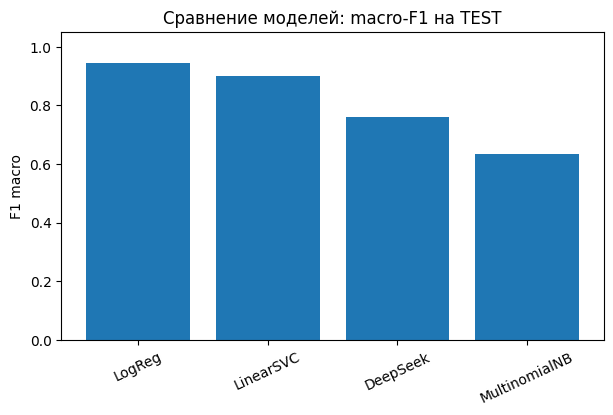

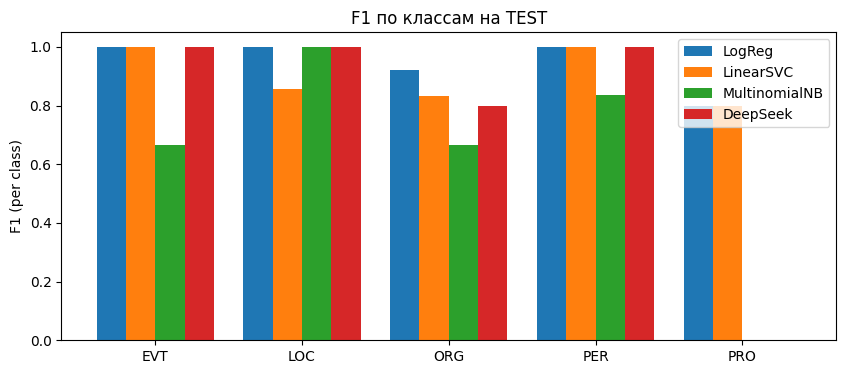

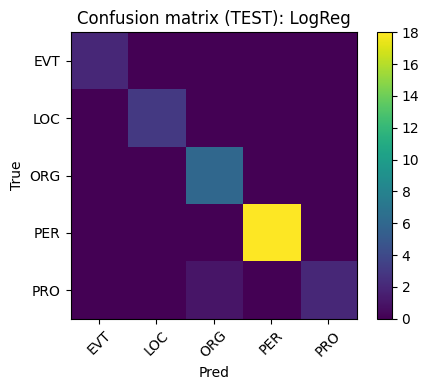

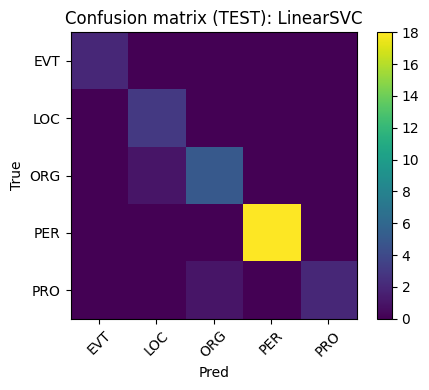

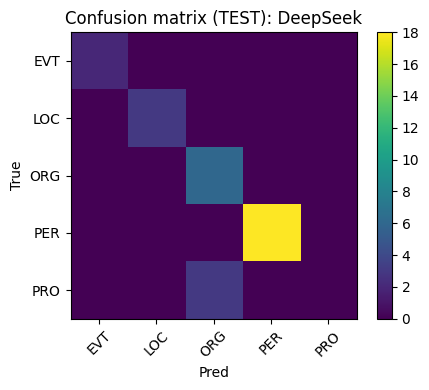

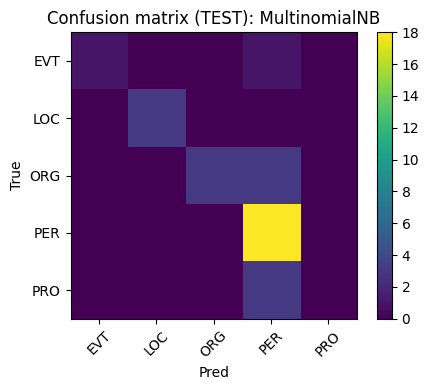

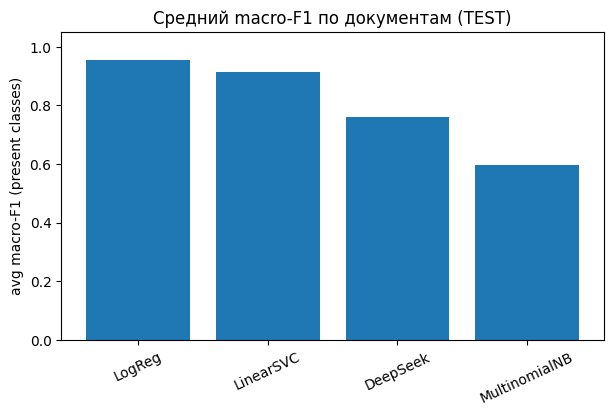

In [208]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, precision_recall_fscore_support
)

df_train_eval = df_train.reset_index(drop=True).copy()
df_test_eval  = df_test.reset_index(drop=True).copy()

CLASSES = list(le.classes_)
n_classes = len(CLASSES)
label_ids = np.arange(n_classes)

models = {
    "LogReg": joblib.load("LogReg_brexit_ner.joblib"),
    "LinearSVC": joblib.load("LinearSVC_brexit_ner.joblib"),
    "MultinomialNB": joblib.load("MultinomialNB_brexit_ner.joblib"),
}

def make_X_df(df_split: pd.DataFrame) -> pd.DataFrame:
    return df_split.drop(columns=["gold_answer"], errors="ignore").copy()

def encode_labels(arr, le):
    arr = np.asarray(arr)
    if np.issubdtype(arr.dtype, np.number):
        return arr.astype(int)

    cls2id = {c: i for i, c in enumerate(le.classes_)}
    mapped = np.array([cls2id.get(str(x), -1) for x in arr], dtype=int)

    return mapped

def safe_predict(model, X_df):
    return model.predict(X_df)

X_train_df = make_X_df(df_train_eval)
X_test_df  = make_X_df(df_test_eval)

preds_train = {}
preds_test  = {}

for name, model in models.items():
    y_hat_train_raw = safe_predict(model, X_train_df)
    y_hat_test_raw  = safe_predict(model, X_test_df)

    preds_train[name] = pd.Series(encode_labels(y_hat_train_raw, le), index=df_train_eval.index)
    preds_test[name]  = pd.Series(encode_labels(y_hat_test_raw, le),  index=df_test_eval.index)

masks_train = {name: np.ones(len(df_train_eval), dtype=bool) for name in preds_train.keys()}
masks_test  = {name: np.ones(len(df_test_eval), dtype=bool)  for name in preds_test.keys()}

def add_deepseek(df_split, preds_dict, masks_dict, split_name):
    if "deepseek_pred" not in df_split.columns:
        print(f"DeepSeek: в {split_name} нет deepseek_pred — пропуск.")
        return

    mask = df_split["deepseek_pred"].notna().to_numpy()
    if mask.sum() == 0:
        print(f"DeepSeek: deepseek_pred пустой на {split_name} — пропуск.")
        return

    ds_ids = encode_labels(df_split["deepseek_pred"].astype(str).to_numpy(), le)
    preds_dict["DeepSeek"] = pd.Series(ds_ids, index=df_split.index)
    masks_dict["DeepSeek"] = mask
    print(f"DeepSeek: добавлен на {split_name}: {mask.sum()} / {len(df_split)} строк")

add_deepseek(df_train_eval, preds_train, masks_train, "TRAIN")
add_deepseek(df_test_eval,  preds_test,  masks_test,  "TEST")

def evaluate_split(df_split, preds_by_model, masks_by_model, split_name):
    y_true_all = le.transform(df_split["gold_answer"].astype(str))
    rows = []

    for name, pred_ser in preds_by_model.items():
        mask = masks_by_model.get(name, np.ones(len(df_split), dtype=bool))
        y_true = y_true_all[mask]
        y_pred = pred_ser.to_numpy()[mask]

        rows.append({
            "split": split_name,
            "model": name,
            "n_eval": int(mask.sum()),
            "accuracy": accuracy_score(y_true, y_pred),
            "precision_macro": precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)[0],
            "recall_macro": precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)[1],
            "f1_micro": f1_score(y_true, y_pred, average="micro"),
            "f1_macro": f1_score(y_true, y_pred, average="macro"),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        })

    return pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)

res_train = evaluate_split(df_train_eval, preds_train, masks_train, "train")
res_test = evaluate_split(df_test_eval,  preds_test,  masks_test,  "test")

print("=== TRAIN (sorted by macro-F1) ===")
display(res_train)

print("=== TEST (sorted by macro-F1) ===")
display(res_test)

gap = res_train.merge(res_test, on="model", suffixes=("_train","_test"), how="inner")
gap["f1_macro_gap"] = gap["f1_macro_train"] - gap["f1_macro_test"]
gap = gap[["model", "f1_macro_train", "f1_macro_test", "f1_macro_gap", "accuracy_train", "accuracy_test"]] \
        .sort_values("f1_macro_gap", ascending=False)

print("=== Train vs Test gap (warning: DeepSeek не 'trainable') ===")
display(gap)

def per_class_f1(df_split, preds_by_model, masks_by_model):
    y_true_all = le.transform(df_split["gold_answer"].astype(str))
    out = pd.DataFrame(index=le.classes_)

    for name, pred_ser in preds_by_model.items():
        mask = masks_by_model.get(name, np.ones(len(df_split), dtype=bool))
        y_true = y_true_all[mask]
        y_pred = pred_ser.to_numpy()[mask]

        _, _, f1s, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=label_ids, zero_division=0
        )
        out[name] = f1s

    return out

f1_by_class_test = per_class_f1(df_test_eval, preds_test, masks_test)
print("=== F1 per class (TEST) ===")
display(f1_by_class_test)

def per_document_metrics(df_split, preds_by_model, masks_by_model):
    rows = []
    y_true_all = le.transform(df_split["gold_answer"].astype(str))

    for doc_id, g in df_split.groupby("document_id"):
        idx = g.index
        y_true_doc = y_true_all[idx.to_numpy()]
        present = np.unique(y_true_doc)

        for name, pred_ser in preds_by_model.items():
            mask_model = masks_by_model.get(name, np.ones(len(df_split), dtype=bool))
            idx_masked = idx[mask_model[idx.to_numpy()]]

            if len(idx_masked) == 0:
                continue

            y_true = y_true_all[idx_masked.to_numpy()]
            y_pred = pred_ser.loc[idx_masked].to_numpy()
            present_local = np.unique(y_true)

            rows.append({
                "document_id": doc_id,
                "model": name,
                "n_mentions": int(len(idx_masked)),
                "accuracy": accuracy_score(y_true, y_pred),
                "f1_macro_present": f1_score(y_true, y_pred, labels=present_local, average="macro"),
            })

    return pd.DataFrame(rows)

doc_metrics_test = per_document_metrics(df_test_eval, preds_test, masks_test)
print("=== Per-document metrics (TEST) ===")
display(doc_metrics_test.sort_values(["document_id","model"]))

def plot_overall_bar(results_df, title):
    plt.figure(figsize=(7, 4))
    plt.bar(results_df["model"], results_df["f1_macro"])
    plt.ylabel("F1 macro")
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=25)
    plt.show()

def plot_per_class_bars(f1_table, title):
    classes = f1_table.index.tolist()
    models_ = f1_table.columns.tolist()
    x = np.arange(len(classes))
    width = 0.8 / max(1, len(models_))

    plt.figure(figsize=(10, 4))
    for i, m in enumerate(models_):
        plt.bar(x + i*width, f1_table[m].values, width=width, label=m)
    plt.xticks(x + width*(len(models_)-1)/2, classes)
    plt.ylim(0, 1.05)
    plt.ylabel("F1 (per class)")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_confusion_matrix(df_split, pred_ser, mask, title):
    y_true_all = le.transform(df_split["gold_answer"].astype(str))
    y_true = y_true_all[mask]
    y_pred = pred_ser.to_numpy()[mask]

    cm = confusion_matrix(y_true, y_pred, labels=label_ids)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks(label_ids, CLASSES, rotation=45)
    plt.yticks(label_ids, CLASSES)
    plt.colorbar()
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_overall_bar(res_test, "Сравнение моделей: macro-F1 на TEST")
plot_per_class_bars(f1_by_class_test, "F1 по классам на TEST")

for name in res_test["model"].tolist():
    plot_confusion_matrix(
        df_test_eval,
        preds_test[name],
        masks_test.get(name, np.ones(len(df_test_eval), dtype=bool)),
        f"Confusion matrix (TEST): {name}"
    )

doc_mean = doc_metrics_test.groupby("model")["f1_macro_present"].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(7,4))
plt.bar(doc_mean["model"], doc_mean["f1_macro_present"])
plt.ylim(0, 1.05)
plt.ylabel("avg macro-F1 (present classes)")
plt.title("Средний macro-F1 по документам (TEST)")
plt.xticks(rotation=25)
plt.show()

В этом задании я сравнил все модели LogReg, LinearSVC, MultinomialNB и baseline от DeepSeek. Для каждой модели посчитал стандартные метрики на train и test, а также построил confusion matrix и графики сравнения.

Общий результат на TEST (macro-F1):
- LogReg - ~= 0.945 (лучший результат)
- LinearSVC - ~= 0.898  
- DeepSeek - ~= 0.760  
- MultinomialNB - ~= 0.634  

По графикам и confusion matrix видно, что ошибки в основном связаны с более редкими и сложными классами.  
В таблице F1 по классам на test DeepSeek полностью проваливает PRO (F1 = 0), а MultinomialNB также плохо справляется с этим классом. LogReg и LinearSVC выглядят стабильнее и лучше держат баланс по всем типам сущностей.

Агрегация по документам показала, что LogReg даёт лучшие или равные результаты на каждом из тестовых документов так как у нас их всего два, поэтому выводы ограничены.

В сравнении Train и Test я получил, что у LinearSVC на train macro-F1 = 1.0, а на test заметно ниже (~= 0.898), значит есть признаки переобучения. Еще я получил, что у LogReg разрыв меньше от 0.987 до 0.945, что выглядит более устойчиво. Ну и MultinomialNB слаб и на train, и на test, отсюда скорее недообучение или слишком простая модель для текущих признаков.

Модель LogReg лучшая, потому что она даёт максимальный macro-F1 на test и меньший разрыв train-test, чем LinearSVC. Вероятно, регуляризация в логистической регрессии помогает лучше обобщать на новых документах при маленьком датасете.

$$$$

Итого среди классических моделей лучше всего подошла LogReg. Однако из-за малого числа документов финальные выводы стоит подтверждать, например, расширением датасета.

### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


,document_id,split,model,n_mentions,doc_len_words,doc_len_chars,accuracy,f1_macro_present
7,ru-1000,test,DeepSeek,14,114.0,879.0,0.857143,0.750000
5,ru-1000,test,LinearSVC,14,114.0,879.0,0.928571,0.904762
4,ru-1000,test,LogReg,14,114.0,879.0,0.928571,0.904762
6,ru-1000,test,MultinomialNB,14,114.0,879.0,0.642857,0.447368
31,ru-1011,test,DeepSeek,18,227.0,1641.0,0.944444,0.771429
29,ru-1011,test,LinearSVC,18,227.0,1641.0,0.944444,0.920000
28,ru-1011,test,LogReg,18,227.0,1641.0,1.000000,1.000000
30,ru-1011,test,MultinomialNB,18,227.0,1641.0,0.888889,0.743333
11,ru-1001,train,DeepSeek,14,95.0,690.0,1.000000,1.000000
9,ru-1001,train,LinearSVC,14,95.0,690.0,1.000000,1.000000



=== document length against metrics ===


,model,"corr(words, f1_macro_present)","corr(chars, f1_macro_present)","corr(words, accuracy)"
3,DeepSeek,0.105187,0.103752,0.138725
1,LinearSVC,-0.949495,-0.953335,-0.971176
0,LogReg,-0.924402,-0.927873,-0.951879
2,MultinomialNB,-0.354160,-0.354701,-0.758407


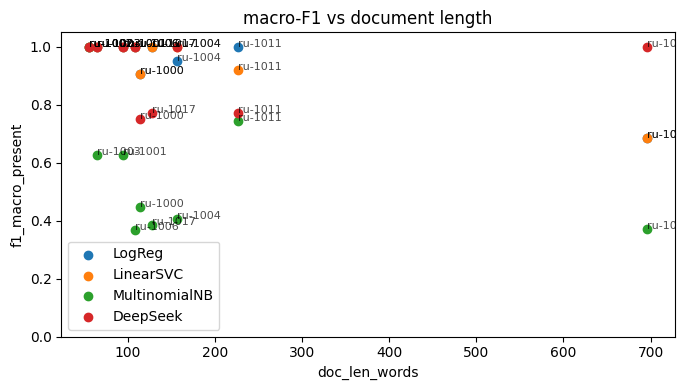

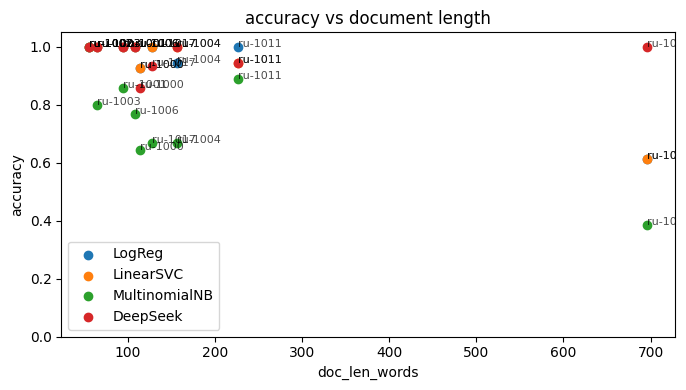


=== Train metrics ===


,model,accuracy,f1_macro,f1_micro
0,LinearSVC,1.000000,1.000000,1.000000
1,LogReg,0.987013,0.987187,0.987013
2,DeepSeek,0.987013,0.928205,0.987013
3,MultinomialNB,0.766234,0.506667,0.766234



=== Test metrics ===


,model,accuracy,f1_macro,f1_micro
0,LogReg,0.96875,0.944615,0.96875
1,LinearSVC,0.93750,0.898095,0.93750
2,DeepSeek,0.90625,0.760000,0.90625
3,MultinomialNB,0.78125,0.634109,0.78125



=== Train and Test gap ===


,model,accuracy_train,f1_macro_train,f1_micro_train,accuracy_test,f1_macro_test,f1_micro_test,f1_macro_gap
0,DeepSeek,0.987013,0.928205,0.987013,0.90625,0.760000,0.90625,0.168205
1,LinearSVC,1.000000,1.000000,1.000000,0.93750,0.898095,0.93750,0.101905
2,LogReg,0.987013,0.987187,0.987013,0.96875,0.944615,0.96875,0.042572
3,MultinomialNB,0.766234,0.506667,0.766234,0.78125,0.634109,0.78125,-0.127442


In [209]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

models = {
    "LogReg": joblib.load("LogReg_brexit_ner.joblib"),
    "LinearSVC": joblib.load("LinearSVC_brexit_ner.joblib"),
    "MultinomialNB": joblib.load("MultinomialNB_brexit_ner.joblib"),
}

CLASSES = list(le.classes_)
n_classes = len(CLASSES)
label_ids = np.arange(n_classes)

def _encode_pred_to_ids(y_pred, le):
    y_pred = np.asarray(y_pred)
    if np.issubdtype(y_pred.dtype, np.number):
        return y_pred.astype(int)
    cls2id = {c: i for i, c in enumerate(le.classes_)}
    mapped = np.array([cls2id.get(str(x), -1) for x in y_pred], dtype=int)
    if (mapped == -1).any():
        bad = sorted(set(y_pred[mapped == -1].astype(str)))
        raise ValueError(f"Unknown labels from model: {bad}. Expected: {list(le.classes_)}")
    return mapped

def safe_predict(model, X_df, X_vec=None):
    try:
        return model.predict(X_df)
    except Exception as e_df:
        if X_vec is not None:
            return model.predict(X_vec)
        raise RuntimeError(f"Predict failed on DataFrame input: {repr(e_df)}")

def make_X_df(df_split):
    return df_split.drop(columns=["gold_answer"], errors="ignore").copy()

df_all = pd.concat([
    df_train.assign(split="train"),
    df_val.assign(split="val"),
    df_test.assign(split="test"),
], axis=0).reset_index(drop=True)

required_cols = {"document_id", "document_text", "entity", "gold_answer"}
missing = required_cols - set(df_all.columns)
if missing:
    raise KeyError(f"df_all missing columns: {missing}")

doc_text = (df_all.groupby("document_id")["document_text"].first()).astype(str)

doc_stats = pd.DataFrame({
    "document_id": doc_text.index,
    "doc_len_chars": doc_text.str.len().values,
    "doc_len_words": doc_text.str.split().str.len().values,
})

df_all = df_all.merge(doc_stats, on="document_id", how="left")

X_all_df = make_X_df(df_all)
y_true_all = le.transform(df_all["gold_answer"].astype(str))

preds_all = {}

for name, model in models.items():
    y_pred_raw = safe_predict(model, X_all_df)
    preds_all[name] = _encode_pred_to_ids(y_pred_raw, le)

if "deepseek_pred" in df_all.columns and df_all["deepseek_pred"].notna().sum() > 0:
    preds_all["DeepSeek"] = _encode_pred_to_ids(df_all["deepseek_pred"].astype(str).values, le)
else:
    print("DeepSeek predictions not found in df_all then skipping DeepSeek")

rows = []
doc_groups = df_all.groupby("document_id").indices

for doc_id, idx in doc_groups.items():
    idx = np.asarray(idx, dtype=int)
    y_t = y_true_all[idx]
    present = np.unique(y_t)

    split_name = df_all.loc[idx[0], "split"]
    doc_len_words = float(df_all.loc[idx[0], "doc_len_words"])
    doc_len_chars = float(df_all.loc[idx[0], "doc_len_chars"])
    n_mentions = len(idx)

    for model_name, y_pred_all in preds_all.items():
        y_p = y_pred_all[idx]
        rows.append({
            "document_id": doc_id,
            "split": split_name,
            "model": model_name,
            "n_mentions": n_mentions,
            "doc_len_words": doc_len_words,
            "doc_len_chars": doc_len_chars,
            "accuracy": accuracy_score(y_t, y_p),
            "f1_macro_present": f1_score(y_t, y_p, labels=present, average="macro"),
        })

doc_metrics = pd.DataFrame(rows)
display(doc_metrics.sort_values(["split","document_id","model"]))

def corr_safe(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2 or np.std(x) == 0 or np.std(y) == 0:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])

corr_rows = []
for model_name in doc_metrics["model"].unique():
    sub = doc_metrics[doc_metrics["model"] == model_name].copy()
    corr_rows.append({
        "model": model_name,
        "corr(words, f1_macro_present)": corr_safe(sub["doc_len_words"], sub["f1_macro_present"]),
        "corr(chars, f1_macro_present)": corr_safe(sub["doc_len_chars"], sub["f1_macro_present"]),
        "corr(words, accuracy)": corr_safe(sub["doc_len_words"], sub["accuracy"]),
    })

corr_df = pd.DataFrame(corr_rows).sort_values("model")
print("\n=== document length against metrics ===")
display(corr_df)

def plot_metric_vs_len(metric_col, len_col, title):
    plt.figure(figsize=(7, 4))
    for model_name in doc_metrics["model"].unique():
        sub = doc_metrics[doc_metrics["model"] == model_name]
        plt.scatter(sub[len_col], sub[metric_col], label=model_name)
        for _, r in sub.iterrows():
            plt.annotate(r["document_id"], (r[len_col], r[metric_col]), fontsize=8, alpha=0.7)

    plt.xlabel(len_col)
    plt.ylabel(metric_col)
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric_vs_len(
    metric_col="f1_macro_present",
    len_col="doc_len_words",
    title="macro-F1 vs document length"
)

plot_metric_vs_len(
    metric_col="accuracy",
    len_col="doc_len_words",
    title="accuracy vs document length"
)

def eval_split(df_split, preds_dict):
    y_true = le.transform(df_split["gold_answer"].astype(str))
    out = []
    for model_name, y_pred_all in preds_dict.items():
        out.append({
            "model": model_name,
            "accuracy": accuracy_score(y_true, y_pred_all),
            "f1_macro": f1_score(y_true, y_pred_all, average="macro"),
            "f1_micro": f1_score(y_true, y_pred_all, average="micro"),
        })
    return pd.DataFrame(out)

def preds_on_split(df_split):
    X_df = make_X_df(df_split)
    y_true = le.transform(df_split["gold_answer"].astype(str))
    preds = {}
    for name, model in models.items():
        preds[name] = _encode_pred_to_ids(safe_predict(model, X_df), le)

    if "deepseek_pred" in df_split.columns and df_split["deepseek_pred"].notna().sum() > 0:
        preds["DeepSeek"] = _encode_pred_to_ids(df_split["deepseek_pred"].astype(str).values, le)

    return preds

preds_train = preds_on_split(df_train)
preds_test  = preds_on_split(df_test)

train_eval = eval_split(df_train, preds_train).sort_values("f1_macro", ascending=False).reset_index(drop=True)
test_eval  = eval_split(df_test,  preds_test ).sort_values("f1_macro", ascending=False).reset_index(drop=True)

print("\n=== Train metrics ===")
display(train_eval)

print("\n=== Test metrics ===")
display(test_eval)

gap = train_eval.merge(test_eval, on="model", suffixes=("_train","_test"), how="inner")
gap["f1_macro_gap"] = gap["f1_macro_train"] - gap["f1_macro_test"]
gap = gap.sort_values("f1_macro_gap", ascending=False).reset_index(drop=True)

print("\n=== Train and Test gap ===")
display(gap)

Я посчитал длину каждого документа (в словах, символах) и метрики по документу accuracy и `f1_macro_present`, затем построил scatter-графики и корреляции. У LogReg и LinearSVC вышла сильная отрицательная корреляция с длиной ~= −0.92...−0.97, но это почти наверняка эффект малого числа документов. Один очень длинный текст `ru-10` сильно тянет статистику. У DeepSeek связь с длиной почти отсутствует, у MultinomialNB она слабая и неустойчивая.

$$$$

LogReg показывает небольшой разрыв gap ~= 0.04, что выглядит как нормальная генерализация.  
LinearSVC имеет заметный разрыв (gap ~= 0.10), значит есть признаки переобучения.  
MultinomialNB в целом слабый на train и test это скорее из-за недообучения.  
DeepSeek - baseline, поэтому train/test gap для него интерпретируем осторожно.

$$$$

Если всё же переобучение, то усилить регуляризацию, ограничить контекст (меньше `max_features` и выше `min_df`), оценивать через CV по документам.  
Если недообучение, то надо добавить признаки n-граммы, окно контекста. Надо еще тюнить NB (alpha), либо брать более сильную модель и больше данных.

Ограничение. Всего 9 документов, поэтому выводы про корреляции и bias и variance могут сильно меняться при другом разбиении.

### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


In [210]:
import numpy as np
import pandas as pd
import joblib

models = {
    "LogReg": joblib.load("LogReg_brexit_ner.joblib"),
    "LinearSVC": joblib.load("LinearSVC_brexit_ner.joblib"),
    "MultinomialNB": joblib.load("MultinomialNB_brexit_ner.joblib"),
}

CLASSES = list(le.classes_)
cls2id = {c: i for i, c in enumerate(CLASSES)}
id2cls = {i: c for c, i in cls2id.items()}

def safe_predict(model, X_df):
    return model.predict(X_df)

def _encode_to_ids(y_pred):
    y_pred = np.asarray(y_pred)
    if np.issubdtype(y_pred.dtype, np.number):
        return y_pred.astype(int)
    mapped = np.array([cls2id.get(str(x), -1) for x in y_pred], dtype=int)
    if (mapped == -1).any():
        bad = sorted(set(np.asarray(y_pred)[mapped == -1].astype(str)))
        raise ValueError(f"Unknown labels: {bad}")
    return mapped

df_test_local = df_test.copy()
X_test_df = df_test_local.drop(columns=["gold_answer"], errors="ignore").copy()

preds = {}
for name, model in models.items():
    preds[name] = _encode_to_ids(safe_predict(model, X_test_df))

if "deepseek_pred" in df_test_local.columns and df_test_local["deepseek_pred"].notna().sum() > 0:
    preds["DeepSeek"] = _encode_to_ids(df_test_local["deepseek_pred"].astype(str).values)

for name, y_hat in preds.items():
    df_test_local[f"pred_{name}"] = [id2cls[i] for i in y_hat]

df_test_local["gold"] = df_test_local["gold_answer"].astype(str)

rows = []
for name in preds.keys():
    pred_col = f"pred_{name}"
    tmp = df_test_local[["document_id", "entity", "document_text", "gold", pred_col]].copy()
    tmp["row_id"] = tmp.index
    tmp = tmp.rename(columns={pred_col: "pred"})
    tmp["model"] = name
    tmp["correct"] = (tmp["gold"] == tmp["pred"])
    rows.append(tmp)

err_df = pd.concat(rows, ignore_index=True)
display(err_df.head())

,document_id,entity,document_text,gold,pred,row_id,model,correct
0,ru-1000,Brexit,Подробности.ua: Третий за сутки: Борис Джонсон...,EVT,EVT,0,LogReg,True
1,ru-1000,The Guardian,Подробности.ua: Третий за сутки: Борис Джонсон...,PRO,PRO,1,LogReg,True
2,ru-1000,Борис Джонсон,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,PER,2,LogReg,True
3,ru-1000,Бориса Джонсона,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,PER,3,LogReg,True
4,ru-1000,Бориса,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,PER,4,LogReg,True


In [211]:

err_by_class = (
    err_df.groupby(["model", "gold"])
          .agg(n=("correct","size"), n_wrong=("correct", lambda x: (~x).sum()))
          .reset_index()
)
err_by_class["error_rate"] = err_by_class["n_wrong"] / err_by_class["n"]
display(err_by_class.sort_values(["model","error_rate"], ascending=[True, False]))


def top_confusions(model_name, topn=10):
    sub = err_df[(err_df["model"] == model_name) & (~err_df["correct"])].copy()
    if len(sub) == 0:
        print(model_name, ": no errors")
        return
    c = sub.groupby(["gold","pred"]).size().reset_index(name="count").sort_values("count", ascending=False)
    print(f"\nTop confusions for {model_name}:")
    display(c.head(topn))

for m in err_df["model"].unique():
    top_confusions(m, topn=10)

,model,gold,n,n_wrong,error_rate
4,DeepSeek,PRO,3,3,1.000000
0,DeepSeek,EVT,2,0,0.000000
1,DeepSeek,LOC,3,0,0.000000
2,DeepSeek,ORG,6,0,0.000000
3,DeepSeek,PER,18,0,0.000000
9,LinearSVC,PRO,3,1,0.333333
7,LinearSVC,ORG,6,1,0.166667
5,LinearSVC,EVT,2,0,0.000000
6,LinearSVC,LOC,3,0,0.000000
8,LinearSVC,PER,18,0,0.000000



Top confusions for LogReg:


,gold,pred,count
0,PRO,ORG,1



Top confusions for LinearSVC:


,gold,pred,count
0,ORG,LOC,1
1,PRO,ORG,1



Top confusions for MultinomialNB:


,gold,pred,count
1,ORG,PER,3
2,PRO,PER,3
0,EVT,PER,1



Top confusions for DeepSeek:


,gold,pred,count
0,PRO,ORG,3


In [212]:
wide = err_df.pivot_table(
    index=["document_id","entity","gold"],
    columns="model",
    values="pred",
    aggfunc="first"
).reset_index()

for m in preds.keys():
    wide[f"ok_{m}"] = (wide[m] == wide["gold"])

ok_cols = [f"ok_{m}" for m in preds.keys()]
wide["all_wrong"] = ~wide[ok_cols].all(axis=1)
hard = wide[wide[ok_cols].sum(axis=1) == 0].copy()
print("Hard cases (all models wrong):", len(hard))
display(hard.head(20))

if "DeepSeek" in preds:
    better = wide[(wide["ok_LogReg"]) & (~wide["ok_DeepSeek"])].copy()
    print("LogReg correct & DeepSeek wrong:", len(better))
    display(better.head(30))

    worse = wide[(~wide["ok_LogReg"]) & (wide["ok_DeepSeek"])].copy()
    print("DeepSeek correct & LogReg wrong:", len(worse))
    display(worse.head(30))

Hard cases (all models wrong): 1


model,document_id,entity,gold,DeepSeek,LinearSVC,LogReg,MultinomialNB,ok_LogReg,ok_LinearSVC,ok_MultinomialNB,ok_DeepSeek,all_wrong
10,ru-1000,Подробности.ua,PRO,ORG,ORG,ORG,PER,False,False,False,False,True


LogReg correct & DeepSeek wrong: 2


model,document_id,entity,gold,DeepSeek,LinearSVC,LogReg,MultinomialNB,ok_LogReg,ok_LinearSVC,ok_MultinomialNB,ok_DeepSeek,all_wrong
1,ru-1000,The Guardian,PRO,ORG,PRO,PRO,PER,True,True,False,False,True
15,ru-1011,The Guardian,PRO,ORG,PRO,PRO,PER,True,True,False,False,True


DeepSeek correct & LogReg wrong: 0


model,document_id,entity,gold,DeepSeek,LinearSVC,LogReg,MultinomialNB,ok_LogReg,ok_LinearSVC,ok_MultinomialNB,ok_DeepSeek,all_wrong


In [213]:
train_ent_freq = df_train["entity"].astype(str).value_counts()
err_df["entity_freq_train"] = err_df["entity"].astype(str).map(train_ent_freq).fillna(0).astype(int)

def has_latin(s):
    return bool(re.search(r"[A-Za-z]", str(s)))
def has_digits(s):
    return bool(re.search(r"\d", str(s)))

err_df["ent_len"] = err_df["entity"].astype(str).str.len()
err_df["ent_has_latin"] = err_df["entity"].apply(has_latin)
err_df["ent_has_digits"] = err_df["entity"].apply(has_digits)

err_df["doc_len_words"] = err_df["document_text"].astype(str).str.split().str.len()

def error_rate_by_bin(df, col, bins, model):
    sub = df[df["model"] == model].copy()
    sub["bin"] = pd.cut(sub[col], bins=bins, include_lowest=True)
    out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
    out["n"] = sub.groupby("bin").size().values
    return out

bins_freq = [-1, 0, 1, 2, 5, 1000]
bins_len  = [0, 4, 7, 10, 20, 1000]

for m in err_df["model"].unique():
    print(f"\n=== {m}: error rate vs entity frequency in train ===")
    display(error_rate_by_bin(err_df, "entity_freq_train", bins_freq, m))

    print(f"=== {m}: error rate vs entity length ===")
    display(error_rate_by_bin(err_df, "ent_len", bins_len, m))


=== LogReg: error rate vs entity frequency in train ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-1.001, 0.0]",0.142857,7
1,"(0.0, 1.0]",0.000000,6
2,"(1.0, 2.0]",0.000000,1
3,"(2.0, 5.0]",0.000000,18
4,"(5.0, 1000.0]",NaN,0


=== LogReg: error rate vs entity length ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-0.001, 4.0]",0.000000,4
1,"(4.0, 7.0]",0.000000,5
2,"(7.0, 10.0]",0.000000,7
3,"(10.0, 20.0]",0.066667,15
4,"(20.0, 1000.0]",0.000000,1



=== LinearSVC: error rate vs entity frequency in train ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-1.001, 0.0]",0.285714,7
1,"(0.0, 1.0]",0.000000,6
2,"(1.0, 2.0]",0.000000,1
3,"(2.0, 5.0]",0.000000,18
4,"(5.0, 1000.0]",NaN,0


=== LinearSVC: error rate vs entity length ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-0.001, 4.0]",0.000000,4
1,"(4.0, 7.0]",0.000000,5
2,"(7.0, 10.0]",0.000000,7
3,"(10.0, 20.0]",0.133333,15
4,"(20.0, 1000.0]",0.000000,1



=== MultinomialNB: error rate vs entity frequency in train ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-1.001, 0.0]",0.285714,7
1,"(0.0, 1.0]",0.500000,6
2,"(1.0, 2.0]",0.000000,1
3,"(2.0, 5.0]",0.111111,18
4,"(5.0, 1000.0]",NaN,0


=== MultinomialNB: error rate vs entity length ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-0.001, 4.0]",0.500000,4
1,"(4.0, 7.0]",0.200000,5
2,"(7.0, 10.0]",0.000000,7
3,"(10.0, 20.0]",0.266667,15
4,"(20.0, 1000.0]",0.000000,1



=== DeepSeek: error rate vs entity frequency in train ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-1.001, 0.0]",0.142857,7
1,"(0.0, 1.0]",0.333333,6
2,"(1.0, 2.0]",0.000000,1
3,"(2.0, 5.0]",0.000000,18
4,"(5.0, 1000.0]",NaN,0


=== DeepSeek: error rate vs entity length ===


/tmp/ipython-input-562368773.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = sub.groupby("bin")["correct"].apply(lambda x: 1 - x.mean()).reset_index(name="error_rate")
/tmp/ipython-input-562368773.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = sub.groupby("bin").size().values


,bin,error_rate,n
0,"(-0.001, 4.0]",0.0,4
1,"(4.0, 7.0]",0.0,5
2,"(7.0, 10.0]",0.0,7
3,"(10.0, 20.0]",0.2,15
4,"(20.0, 1000.0]",0.0,1


In [214]:
def get_feature_names_from_union(pipe):
    feat = pipe.named_steps["features"]
    names = []

    for prefix, transformer in feat.transformer_list:
        vec = transformer.named_steps["tfidf"]
        try:
            fn = vec.get_feature_names_out()
        except Exception:
            fn = vec.get_feature_names()
        names.extend([f"{prefix}__{x}" for x in fn])

    return np.array(names)

def top_features_per_class(pipe, class_name, topn=20):
    clf = pipe.named_steps["clf"]
    if not hasattr(clf, "coef_"):
        raise ValueError("Classifier has no coef_ (not linear?)")

    feat_names = get_feature_names_from_union(pipe)
    class_id = cls2id[class_name]
    w = clf.coef_[class_id]

    top_pos = np.argsort(w)[-topn:][::-1]
    top_neg = np.argsort(w)[:topn]

    return (
        pd.DataFrame({"feature": feat_names[top_pos], "weight": w[top_pos]})
        , pd.DataFrame({"feature": feat_names[top_neg], "weight": w[top_neg]})
    )

logreg = models["LogReg"]

for c in CLASSES:
    pos, neg = top_features_per_class(logreg, c, topn=15)
    print(f"\n=== LogReg top positive features for class {c} ===")
    display(pos)


=== LogReg top positive features for class EVT ===


,feature,weight
0,entity__brex,0.677457
1,entity__rex,0.677457
2,entity__br,0.677457
3,entity__bre,0.677457
4,entity__it,0.677457
5,entity__xi,0.677457
6,entity__rexit,0.677457
7,entity__xit,0.677457
8,entity__brexi,0.677457
9,entity__ex,0.677457



=== LogReg top positive features for class LOC ===


,feature,weight
0,entity__ни,0.412510
1,entity__ан,0.402283
2,entity__ани,0.358204
3,entity__ании,0.358204
4,entity__нии,0.358204
5,entity__рит,0.340746
6,entity__ки,0.317932
7,entity__ие,0.317932
8,entity__кие,0.317932
9,entity__киев,0.317932



=== LogReg top positive features for class ORG ===


,feature,weight
0,entity__ес,1.151047
1,entity__ми,0.476676
2,entity__мид,0.476676
3,entity__ид,0.371416
4,entity__рос,0.324128
5,entity__ос,0.324128
6,entity__унн,0.314683
7,entity__мид,0.289318
8,entity__нн,0.276914
9,entity__сс,0.262808



=== LogReg top positive features for class PER ===


,feature,weight
0,entity__эй,0.595618
1,entity__мэ,0.595618
2,entity__мэй,0.595618
3,entity__он,0.590568
4,entity__ис,0.367499
5,entity__жонсо,0.340862
6,entity__сон,0.340862
7,entity__нсон,0.340862
8,entity__нсо,0.340862
9,entity__джо,0.340862



=== LogReg top positive features for class PRO ===


,feature,weight
0,entity__ok,0.394915
1,entity__ook,0.394915
2,entity__oo,0.394915
3,entity__faceb,0.394915
4,entity__face,0.394915
5,entity__eb,0.394915
6,entity__ebo,0.394915
7,entity__eboo,0.394915
8,entity__ebook,0.394915
9,entity__fa,0.394915


In [215]:
import numpy as np
import pandas as pd

def get_feature_names_from_union(pipe):
    feat = pipe.named_steps["features"]
    names = []
    for prefix, transformer in feat.transformer_list:
        vec = transformer.named_steps["tfidf"]
        try:
            fn = vec.get_feature_names_out()
        except Exception:
            fn = vec.get_feature_names()
        names.extend([f"{prefix}__{x}" for x in fn])
    return np.array(names)

def explain_one_example(pipe, X_one_row_df, le, topn=25):
    """
    Возвращает (pred_label, explanation_df)
    explanation_df: топ-фичи по вкладу (value * weight)
    """
    clf = pipe.named_steps["clf"]
    feat_names = get_feature_names_from_union(pipe)

    pred_raw = pipe.predict(X_one_row_df)[0]

    if isinstance(pred_raw, (int, np.integer)):
        pred_label = le.inverse_transform([int(pred_raw)])[0]
    else:
        pred_label = str(pred_raw)

    classes = np.asarray(clf.classes_)
    idx_row = np.where(classes == pred_raw)[0]
    if len(idx_row) == 0:
        try:
            idx_row = np.where(classes == int(pred_raw))[0]
        except Exception:
            pass
    if len(idx_row) == 0:
        raise RuntimeError(f"Can't find pred={pred_raw} inside clf.classes_={classes}")

    idx_row = int(idx_row[0])
    w = clf.coef_[idx_row]

    Xv = pipe.named_steps["features"].transform(X_one_row_df)
    Xv = Xv.tocsr()

    nz_idx = Xv.indices
    nz_val = Xv.data

    contrib = nz_val * w[nz_idx]
    top = np.argsort(contrib)[-topn:][::-1]

    out = pd.DataFrame({
        "feature": feat_names[nz_idx[top]],
        "tfidf_value": nz_val[top],
        "weight": w[nz_idx[top]],
        "contribution": contrib[top],
    })

    return pred_label, out

ex = err_df[(err_df["model"] == "LogReg") & (~err_df["correct"])].iloc[0]
print("Example:", ex["document_id"], "| entity:", ex["entity"], "| gold:", ex["gold"], "| pred:", ex["pred"])

df_one = X_test_df.loc[[ex["row_id"]]]

pred_label, expl = explain_one_example(models["LogReg"], df_one, le, topn=25)
print("Model predicted:", pred_label)
display(expl)

Example: ru-1000 | entity: Подробности.ua | gold: PRO | pred: ORG
Model predicted: ORG


,feature,tfidf_value,weight,contribution
0,entity__ос,0.283546,0.324128,0.091905
1,entity__ро,0.238739,0.257166,0.061396
2,entity__ти,0.353984,0.080354,0.028444
3,entity__но,0.330068,0.053762,0.017745
4,text__премьер,0.109872,0.035087,0.003855
5,text__джонсон,0.067778,0.048937,0.003317
6,text__за,0.080307,0.033837,0.002717
7,text__министр,0.146496,0.015044,0.002204
8,text__он,0.046016,0.045048,0.002073
9,text__отставку,0.061953,0.030214,0.001872


В этом задании я сделал детальный разбор ошибок моделей на тесте. Сначала я собрал предсказания всех моделей в единую таблицу ошибок `err_df`, где для каждого mention есть `gold`, `pred`, флаг `correct` и `row_id`. Это позволило удобно фильтровать неправильные ответы и анализировать их по разным срезам.

Далее я посмотрел, в каких случаях модели ошибаются чаще всего. Я посчитал error rate по типам сущностей и вывел самые частые пары ошибок вида `gold -> pred`. Отдельно сравнил случаи, где одна модель права, а другая нет, чтобы увидеть различия в паттернах ошибок.

Для интерпретации я использовал то, что модели линейные. Я вывел топ-признаки по весам для каждого класса. В моих результатах видно, что модель сильно опирается на символьные n-граммы entity, что хорошо работает для имён,  аббревиатур и морфологии, и контекстные word n-граммы из документа, которые помогают различать ORG, LOC, EVT в зависимости от тематики текста.

Также я сделал локальное объяснение на конкретной ошибке например `Подробности.ua`: gold=PRO, pred=ORG. Вклад признаков показал, что решение в основном толкали n-граммы из самого mention и часть контекста, поэтому модель отнесла сайт или бренд к ORG, что в целом логично для такой постановки и маленького числа примеров PRO.

По итогам анализа можно предложить конкретные улучшения, а именно:
- Усилить класс PRO. Сделать больше примеров;
- Добавить простые правила или признаки для PRO (например, наличие домена .ru/.ua/.com, латиница);
- Уменьшить шум контекста. Вместо TF-IDF по всему документу брать окно вокруг mention;
- И для моделей со склонностью к переобучению надо усилить регуляризацию , ну или ограничить размерность признаков, или то и другое.

Линейные модели хорошо интерпретируются, ведь можно показать веса и вклад признаков, но качество сильно зависит от признаков и данных. DeepSeek даёт удобный baseline и иногда лучше понимает смысл, но хуже контролируется и может системно путать редкие классы вроде PRO.

### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


**Summarize your findings: Which approach worked best and why?**  
В рамках работы я решал задачу классификации типа сущности на уровне mention, то есть когда само упоминание уже известно. Среди классических моделей лучше всего показала себя Logistic Regression с TF-IDF признаками по `entity` и по `document_text`. На тесте она дала macro-F1 ~= 0.945 и оказалась стабильнее, чем LinearSVC. DeepSeek использовался как baseline и оказался слабее на тесте (macro-F1 ~= 0.76), особенно на редком классе PRO. MultinomialNB в среднем работал хуже остальных.

$$$$

**Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions**  
По разнице train и test видно, что LinearSVC имеет признаки более высокой variance. На train качество идеальное, а на test заметно ниже. LogReg показывает меньший разрыв и выглядит более устойчиво, то есть лучше обобщает. MultinomialNB демонстрирует скорее недообучение из-за сильных наивных предположений о независимости признаков. Линейные модели в целом предполагают, что классы хорошо разделимы линейно в пространстве TF-IDF. Для этой задачи это оказалось достаточно разумным допущением.

$$$$

**What are the limitations of your approach? What assumptions did you make?**  
Главное ограничение это очень маленький датасет всего 9 документов, поэтому метрики на test могут быть нестабильны и сильно зависеть от разбиения. Кроме того, моя постановка это не полноценный NER (sequence labeling), а именно классификация типа сущности для заданного mention. Ещё одно допущение это то что я использовал TF-IDF по всему `document_text`, хотя в длинных документах это может добавлять шум и ухудшать качество.

$$$$

**What would you do differently if you had more time or data?**  
1) Я бы сделал бы более строгую оценку через кросс-валидацию по документам (`document_id`).  
2) Вместо всего текста документа я использовал бы контекстное окно вокруг mention.  
3) Добавил бы простые признаки для редких классов, особенно PRO (домены .ru/.ua/.com).  
4) Попробовал бы sequence-модель, например, CRF или токен-классификацию на трансформерах, если задача была бы поставлена как полноценный NER.

$$$$

**Write what you learned and what new things you tried**  
Я построил end-to-end пайплайн. От парсинга разметки и сборки датасета до обучения нескольких моделей, сравнения метрик и ручного baseline через LLM. Также я сделал кастомные реализации micro и macro-F1 с unit tests и провёл интерпретацию линейной модели через веса признаков и вклад фич на конкретной ошибке.

$$$$

**Reflect on the end-to-end ML workflow: from problem formulation to evaluation**  
Работа показала, что даже простые линейные модели могут давать сильный результат на текстовой классификации при правильно подобранных признаках, но качество сильно зависит от данных и корректной схемы оценки. Сравнение с DeepSeek помогло понять, что LLM удобен как baseline, но может системно ошибаться на редких или нестандартных классах, и для воспроизводимого решения всё равно важны чёткая постановка задачи, контроль метрик и анализ ошибок.


In [216]:
import pandas as pd
import numpy as np
import joblib

best_model = joblib.load("LogReg_brexit_ner.joblib")

df_for_pred = df.copy()

X = df_for_pred.drop(columns=["gold_answer"], errors="ignore").copy()
y_pred_ids = best_model.predict(X)

y_pred = le.inverse_transform(y_pred_ids.astype(int))

out = df_for_pred[["document_id", "entity", "gold_answer"]].copy()
out["pred_LogReg"] = y_pred

if "deepseek_pred" in df_for_pred.columns:
    out["pred_DeepSeek"] = df_for_pred["deepseek_pred"]

out.to_csv("model_predictions.csv", index=False)